In [1]:
# 导入程序所需要的程序包

#PyTorch用的包
import torch
import torch.nn as nn
import torch.optim
#from torch.autograd import Variable

# 自然语言处理相关的包
import re #正则表达式的包
import jieba #结巴分词包
from collections import Counter #搜集器，可以让统计词频更简单

#绘图、计算用的程序包
import matplotlib.pyplot as plt
import numpy as np


In [2]:
# 指定工作目录
import os
os.chdir(r'C:\Users\Family\Desktop\PyTorch\04_Text_classification')

In [3]:
# 数据来源文件
good_file = 'data/good.txt'
bad_file  = 'data/bad.txt'


In [4]:
# 将文本中的标点符号过滤掉；正则[]集合替换
def filter_punc(sentence):
    sentence = re.sub("[\s+\.\!\/_,$%^*(+\"\'“”《》?“]+|[+——！，。？、~@#￥%……&*（）：]+", "", sentence)  
    return(sentence)

In [5]:
#扫描所有的文本，分词、建立词典，分出正向还是负向的评论，is_filter可以过滤是否筛选掉标点符号
def Prepare_data(good_file, bad_file, is_filter = True):
    all_words = [] #存储所有的单词
    pos_sentences = [] #存储正向的评论
    neg_sentences = [] #存储负向的评论
    # encoding='utf-8',保证windows平台使用utf-8编码正常读取(python3)
    with open(good_file, mode='r',encoding='utf-8') as fr:
        for idx, line in enumerate(fr):# index 从0开始
            if is_filter:
                #过滤标点符号
                line = filter_punc(line)
            #jieba模块 分词，返回list 类型
            words = jieba.lcut(line)
            if len(words) > 0:
                all_words += words #list 列表类型之间连接
                pos_sentences.append(words)
    print('{0} 包含 {1} 行, {2} 个词.'.format(good_file, idx+1, len(all_words)))

    count = len(all_words) # good count
    # encoding='utf-8',保证windows平台使用utf-8编码正常读取(python3)
    with open(bad_file,  mode='r',encoding='utf-8') as fr:
        for idx, line in enumerate(fr):
            if is_filter:
                line = filter_punc(line)
            words = jieba.lcut(line)
            if len(words) > 0:
                all_words += words
                neg_sentences.append(words)
    print('{0} 包含 {1} 行, {2} 个词.'.format(bad_file, idx+1, len(all_words)-count))

    #建立词典，diction的每一项为{w:[id, 单词出现次数]}
    diction = {}
    cnt = Counter(all_words) # 词频统计
    for word, freq in cnt.items():
        diction[word] = [len(diction), freq]
    print('字典大小：{}'.format(len(diction)))
    return(pos_sentences, neg_sentences, diction)

In [6]:
#根据单词返还单词的编码 # 根据key 获取value(list) 中的index元素
def word2index(word, diction):
    if word in diction:
        value = diction[word][0]
    else:
        value = -1
    return(value)

#根据编码获得单词 # 迭代 value ,寻找value_list 中对应的index，返回key
def index2word(index, diction):
    for w,v in diction.items():
        if v[0] == index:
            return(w)
    return(None)

In [7]:
'''
读取过滤,分别返回积极消极词的list,以及词频的字典
'''
pos_sentences, neg_sentences, diction = Prepare_data(good_file, bad_file, True)
st = sorted([(v[1], w) for w, v in diction.items()])
# st  [[freq1,word1],[freq2,word2],]

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\Family\AppData\Local\Temp\jieba.cache
Loading model cost 0.524 seconds.
Prefix dict has been built successfully.


data/good.txt 包含 8089 行, 100839 个词.
data/bad.txt 包含 5076 行, 56070 个词.
字典大小：7135


# 词袋模型
## 1. 训练数据准备

In [8]:
# 输入一个句子和相应的词典，得到这个句子的向量化表示
# 向量的尺寸为词典中词汇的个数，i位置上面的数值为第i个单词在sentence中出现的频率
def sentence2vec(sentence, dictionary):
    '''
    词袋中，按顺序位置改为1，累加出现频次； 
    diction  {w:[id, 单词出现次数]}
    
    目标，统计不同分类中某些词会出现频次(权重)，来判断一句话是积极还是负面词汇
    '''
    vector = np.zeros(len(dictionary)) # 向量的尺寸为词典中词汇的个数, 填充0 zeros 零
    for l in sentence:
        vector[l] += 1
    return(1.0 * vector / len(sentence))


In [9]:
# 遍历所有句子，将每一个词映射成编码
dataset = [] #数据集
labels = [] #标签
sentences = [] #原始句子，调试用
# 处理正向评论
for sentence in pos_sentences:
    new_sentence = []
    for l in sentence: # 单词
        if l in diction:
            new_sentence.append(word2index(l, diction)) #根据key 获取value(list) 中的index元素
    dataset.append(sentence2vec(new_sentence, diction)) #
    labels.append(0) #正标签为0
    sentences.append(sentence)

# 处理负向评论
for sentence in neg_sentences:
    new_sentence = []
    for l in sentence:
        if l in diction:
            new_sentence.append(word2index(l, diction))
    dataset.append(sentence2vec(new_sentence, diction))
    labels.append(1) #负标签为1
    sentences.append(sentence)


In [10]:
#打乱所有的数据顺序，形成数据集
# indices为所有数据下标的一个全排列
'''
permutation(x)函数由传入的 x 参数的类型决定功能：

当 x 设置为标量时，返回指定范围值为 [0, x) 的乱序数组；
当 x 设置为数组（本文的所有数组指的都是ndarray数组）、列表以及元组时，则对数组、列表以及元组中的元素值进行乱序排列；
无论几个维度的数组、列表以及元组，permulation(x)函数最终只对第一个维度进行乱序
第一维度是行，第二维度是列
permutation(x)函数最终返回的都是乱序后的数组
'''
indices = np.random.permutation(len(dataset)) 
print(len(dataset))
print(indices)
#类似 range ,不过是乱序的[11138   197  4426 ...  7846  9746  3849]
if len(dataset)-1 in indices and 0 in indices and len(dataset) not in indices:
     print("bingo")

#重新根据打乱的下标生成数据集dataset，标签集labels，以及对应的原始句子sentences
dataset = [dataset[i] for i in indices]
labels = [labels[i] for i in indices]
sentences = [sentences[i] for i in indices]


13031
[ 8284   923  6893 ...  1917 12065  6305]
bingo


In [11]:
#对整个数据集进行划分，分为：训练集、校准集和测试集，其中校准和测试集合的长度都是整个数据集的10分之一
'''
valid_data(1:test_size) + test_data(1*test_size) +train_data(8*test_size)
'''
test_size = len(dataset) // 10 # 10分之1
train_data = dataset[2 * test_size :]
train_label = labels[2 * test_size :]

valid_data = dataset[: test_size]
valid_label = labels[: test_size]

test_data = dataset[test_size : 2 * test_size]
test_label = labels[test_size : 2 * test_size]


## 2. 模型定义

一个简单的前馈神经网络，三层，第一层线性层，加一个非线性ReLU，第二层线性层，中间有10个隐含层神经元

输入维度为词典的大小：每一段评论的词袋模型

In [12]:
'''
nn.Linear参数:
    in_features:输入样本的大小
    out_features:输出样本的大小
    bias:默认为True，可以设置为False，设置后则不会添加偏差
    在实际应用中，nn.Linear往往用来初始化矩阵，供神经网络使用。
    
nn.ReLU: 只获得大于0的部分，其余都等于0
    y= max(0,x)

nn.LogSoftmax: 
    生成0-1 之间的数，总和为1，对应概率
    （1）dim=0：对每一列的所有元素进行softmax运算，并使得每一列所有元素和为1。
    （2）dim=1：对每一行的所有元素进行softmax运算，并使得每一行所有元素和为1。
'''
model = nn.Sequential(
    nn.Linear(len(diction), 10), 
    nn.ReLU(), 
    nn.Linear(10, 2), # 二分概率
    nn.LogSoftmax(dim=1),
)

In [13]:
def rightness(predictions, labels):
    """计算预测错误率的函数，其中predictions是模型给出的一组预测结果，batch_size行num_classes列的矩阵，labels是数据之中的正确答案"""
    pred = torch.max(predictions.data, 1)[1] # 对于任意一行（一个样本）的输出值的第1个维度，求最大，得到每一行的最大元素的下标 
    # print('pred',torch.max(predictions.data, 1))
    # pred torch.return_types.max(values=tensor([-0.1528]),indices=tensor([0]))
    # pred torch.return_types.max( values=tensor([-0.0073]),indices=tensor([1]))
    
    #print(torch.max(predictions.data, 1)[0])
    # tensor([-0.0633])

    # 下标指的应该是 tensor([1]) 就是标签
    '''
    labels.data.view_as(pred) labels 张量自动转换为与 pred 一样 ，前提是元素个数相同
    pred.eq(tensor).sum()
    
    Tensor比较eq相等：
        import torch

        outputs=torch.FloatTensor([[1],[2],[3]])
        targets=torch.FloatTensor([[0],[2],[3]])
        print(targets.eq(outputs.data))
    OUT:
        tensor([[ 0],[ 1],[ 1]], dtype=torch.uint8)
    
    使用sum() 统计相等的个数：
        import torch

        outputs=torch.FloatTensor([[1],[2],[3]])
        targets=torch.FloatTensor([[0],[2],[3]])
        print(targets.eq(outputs.data).cpu().sum())
        
    OUT:
        tensor(2)

    '''
    rights = pred.eq(labels.data.view_as(pred)).sum() #将下标与labels中包含的类别进行比较，并累计得到比较正确的数量
    return rights, len(labels) #返回正确的数量和这一次一共比较了多少元素

## 3. 训练模型
### 损失函数为交叉熵

In [14]:
# 损失函数为交叉熵
cost = torch.nn.NLLLoss()
# 优化算法为Adam，可以自动调节学习率(lr) # 调节lr ,即 变化step步长   一个lr 与 导数的乘积 = 结果(反向传播速度)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.01)
records = []

In [15]:
#循环10个Epoch
losses = []
for epoch in range(10):
    for i, data in enumerate(zip(train_data, train_label)):
        x, y = data
        
        # 需要将输入的数据进行适当的变形，主要是要多出一个batch_size的维度，也即第一个为1的维度
        x = torch.tensor(x, requires_grad = True, dtype = torch.float).view(1,-1) # view 变形 1行，自动列
        # x的尺寸：batch_size=1, len_dictionary # 行，列
        # 标签也要加一层外衣以变成1*1的张量
        y = torch.tensor(np.array([y]), dtype = torch.long)
        # y的尺寸：batch_size=1, 1 # 输出 行，列 
        
        # 清空梯度
        optimizer.zero_grad()
        # 模型预测
        predict = model(x)
        # 计算损失函数
        loss = cost(predict, y)
        # 将损失函数数值加入到列表中
        losses.append(loss.data.numpy())
        # 开始进行梯度反传
        loss.backward()
        # 开始对参数进行一步优化
        optimizer.step()
        
        # 每隔3000步，跑一下校验数据集的数据，输出临时结果
        if i % 3000 == 0:
            val_losses = []
            rights = []
            # 在所有校验数据集上实验
            for j, val in enumerate(zip(valid_data, valid_label)):
                x, y = val
                x = torch.tensor(x, requires_grad = True, dtype = torch.float).view(1,-1)
                y = torch.tensor(np.array([y]), dtype = torch.long)
                predict = model(x)
                # 调用rightness函数计算准确度
                right = rightness(predict, y)
                rights.append(right)
                loss = cost(predict, y)
                val_losses.append(loss.data.numpy())
                
            # 将校验集合上面的平均准确度计算出来
            right_ratio = 1.0 * np.sum([i[0] for i in rights]) / np.sum([i[1] for i in rights])
            print('第{}轮，训练损失：{:.2f}, 校验损失：{:.2f}, 校验准确率: {:.2f}'.format(epoch, np.mean(losses),
                                                                        np.mean(val_losses), right_ratio))
            records.append([np.mean(losses), np.mean(val_losses), right_ratio])

第0轮，训练损失：0.51, 校验损失：0.66, 校验准确率: 0.62
第0轮，训练损失：0.38, 校验损失：0.28, 校验准确率: 0.91
第0轮，训练损失：0.34, 校验损失：0.27, 校验准确率: 0.90
第0轮，训练损失：0.31, 校验损失：0.24, 校验准确率: 0.92
第1轮，训练损失：0.31, 校验损失：0.24, 校验准确率: 0.93
第1轮，训练损失：0.30, 校验损失：0.24, 校验准确率: 0.93
第1轮，训练损失：0.29, 校验损失：0.25, 校验准确率: 0.91
第1轮，训练损失：0.28, 校验损失：0.24, 校验准确率: 0.92
第2轮，训练损失：0.28, 校验损失：0.24, 校验准确率: 0.92
第2轮，训练损失：0.27, 校验损失：0.24, 校验准确率: 0.93
第2轮，训练损失：0.27, 校验损失：0.25, 校验准确率: 0.92
第2轮，训练损失：0.26, 校验损失：0.24, 校验准确率: 0.92
第3轮，训练损失：0.26, 校验损失：0.24, 校验准确率: 0.92
第3轮，训练损失：0.25, 校验损失：0.24, 校验准确率: 0.92
第3轮，训练损失：0.25, 校验损失：0.25, 校验准确率: 0.92
第3轮，训练损失：0.25, 校验损失：0.25, 校验准确率: 0.92
第4轮，训练损失：0.25, 校验损失：0.24, 校验准确率: 0.92
第4轮，训练损失：0.24, 校验损失：0.24, 校验准确率: 0.92
第4轮，训练损失：0.24, 校验损失：0.25, 校验准确率: 0.92
第4轮，训练损失：0.24, 校验损失：0.25, 校验准确率: 0.92
第5轮，训练损失：0.24, 校验损失：0.24, 校验准确率: 0.92
第5轮，训练损失：0.24, 校验损失：0.24, 校验准确率: 0.92
第5轮，训练损失：0.23, 校验损失：0.25, 校验准确率: 0.92
第5轮，训练损失：0.23, 校验损失：0.25, 校验准确率: 0.92
第6轮，训练损失：0.23, 校验损失：0.24, 校验准确率: 0.92
第6轮，训练损失：0.23, 校验损失：0.25, 校验准确率: 0.92
第6轮，训练损失：0.2

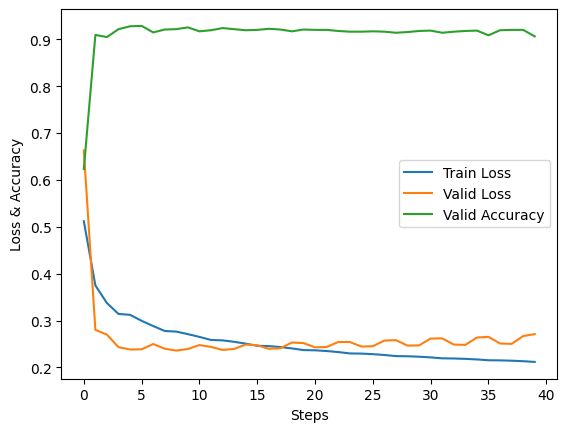

In [16]:
# 绘制误差曲线
a = [i[0] for i in records]
b = [i[1] for i in records]
c = [i[2] for i in records]
plt.plot(a, label = 'Train Loss')
plt.plot(b, label = 'Valid Loss')
plt.plot(c, label = 'Valid Accuracy')
plt.xlabel('Steps')
plt.ylabel('Loss & Accuracy')
plt.legend()

In [17]:
#在测试集上分批运行，并计算总的正确率
vals = [] #记录准确率所用列表

#对测试数据集进行循环
for data, target in zip(test_data, test_label):
    data, target = torch.tensor(data, dtype = torch.float).view(1,-1), torch.tensor(np.array([target]), dtype = torch.long)
    output = model(data) #将特征数据喂入网络，得到分类的输出； mode 就是nn.Sequential()搭建的神经网络层级结构
    val = rightness(output, target) #获得正确样本数以及总样本数
    vals.append(val) #记录结果

#计算准确率
rights = (sum([tup[0] for tup in vals]), sum([tup[1] for tup in vals]))
right_rate = 1.0 * rights[0].data.numpy() / rights[1]
print(right_rate)

0.9132770529547198


# 4. 解剖神经网络

Text(0, 0.5, 'Weights')

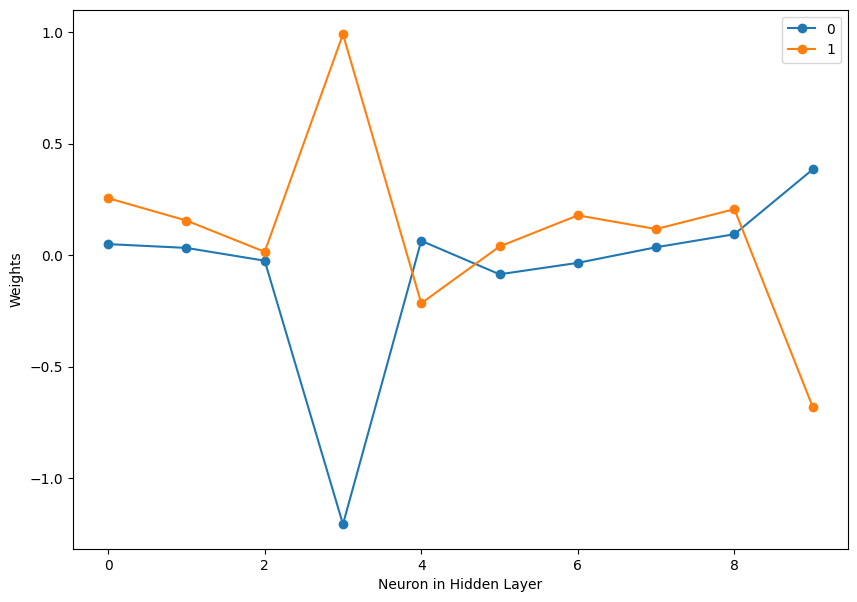

In [18]:
# 将神经网络的架构打印出来，方便后面的访问
#print(model.named_parameters)

# 绘制出第二个全链接层的权重大小
# model[2]即提取第2层，网络一共4层，第0层为线性神经元，第1层为ReLU，第2层为第二层神经原链接，第3层为logsoftmax
plt.figure(figsize = (10, 7)) 
for i in range(model[2].weight.size()[0]): # 10层隐藏层权重
    #if i == 1:
        weights = model[2].weight[i].data.numpy()
        plt.plot(weights, 'o-', label = i)
plt.legend()
plt.xlabel('Neuron in Hidden Layer')
plt.ylabel('Weights')

Text(0, 0.5, 'Weights')

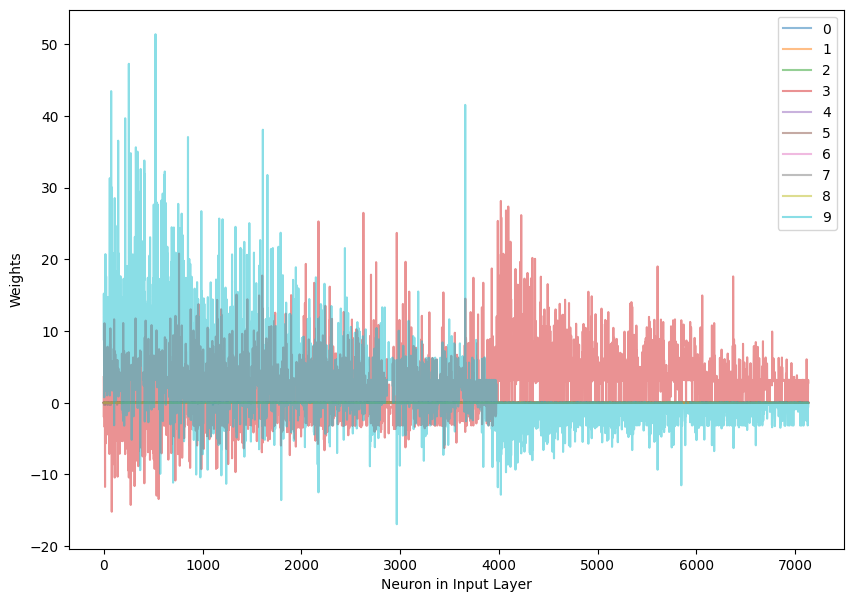

In [19]:
# 将第一层神经元的权重都打印出来，一条曲线表示一个隐含层神经元。横坐标为输入层神经元编号，纵坐标为权重值大小
plt.figure(figsize = (10, 7))
for i in range(model[0].weight.size()[0]): #0层输入层权重
    #if i == 1:
        weights = model[0].weight[i].data.numpy()
        plt.plot(weights, alpha = 0.5, label = i)
plt.legend()
plt.xlabel('Neuron in Input Layer')
plt.ylabel('Weights')

In [20]:
# 将第二层的各个神经元与输入层的链接权重，挑出来最大的权重和最小的权重，并考察每一个权重所对应的单词是什么，把单词打印出来
# model[0]是取出第一层的神经元
'''
for i in range(len(model[0].weight)): # 输入
    print('\n')
    print('第{}个神经元'.format(i))
    print('max:')
    st = sorted([(w,i) for i,w in enumerate(model[0].weight[i].data.numpy())]) #
    print('st',st[0:10])
    
    #weight index
    #最前面/最后面 20个 
    #概率，标签
    #values=tensor([-0.0073]),indices=tensor([1])

    for i in range(1, 20):
        word = index2word(st[-i][1],diction)
        print(word)
    print('min:')
    for i in range(20):
        word = index2word(st[i][1],diction)
        print(word)
'''

"\nfor i in range(len(model[0].weight)): # 输入\n    print('\n')\n    print('第{}个神经元'.format(i))\n    print('max:')\n    st = sorted([(w,i) for i,w in enumerate(model[0].weight[i].data.numpy())]) #\n    print('st',st[0:10])\n    \n    #weight index\n    #最前面/最后面 20个 \n    #概率，标签\n    #values=tensor([-0.0073]),indices=tensor([1])\n\n    for i in range(1, 20):\n        word = index2word(st[-i][1],diction)\n        print(word)\n    print('min:')\n    for i in range(20):\n        word = index2word(st[i][1],diction)\n        print(word)\n"

In [26]:
#2. 寻找判断错误的原因

# 收集到在测试集中判断错误的句子
wrong_sentences = []
targets = []
j = 0
sent_indices = []
for data, target in zip(test_data, test_label):
    #print('for:',data,target)
    '''
    word(向量化的词频) , label
    [0. 0. 0. ... 0. 0. 0.] 1
    [0. 0. 0. ... 0. 0. 0.] 0
    '''
    predictions = model(torch.tensor(data, dtype = torch.float).view(1,-1)) # 1行，自动列
    pred = torch.max(predictions.data, 1)[1]  # 返回行最大的值 ，他的第二个元素[1]
    # print("predictions",torch.max(predictions.data, 1))
    '''
    values=tensor([-0.1528]),indices=tensor([0]
    torch.return_types.max(values=tensor([-0.1528]),indices=tensor([0]))
    '''
    target = torch.tensor(np.array([target]), dtype = torch.long).view_as(pred) # 转为为pred 相同 shap 行列
    rights = pred.eq(target)
    '''
    Tensor比较eq相等：
        import torch

        outputs=torch.FloatTensor([[1],[2],[3]])
        targets=torch.FloatTensor([[0],[2],[3]])
        print(targets.eq(outputs.data))
    OUT:
        tensor([[ 0],[ 1],[ 1]], dtype=torch.uint8)
    '''
    indices = np.where(rights.numpy() == 0)[0] # 获得 不相等的地方(张量多维矩阵)index 就是错误的
    for i in indices:
        wrong_sentences.append(data)
        targets.append(target[i])
        # data, target in zip(test_data, test_label)
        # data  是单词向量化序列
        # target 就是标签
        #print(target[i])
        # sent_indices 就是截取test_size 测试集大小 分出来段落
        sent_indices.append(test_size + j + i)
    j += len(target)

# 逐个查看出错的句子是什么
idx = 1
print('sent_indices',sent_indices)
print('sentences[sent_indices[idx]]',idx,sent_indices[idx],sentences[sent_indices[idx]])
print(targets[idx].numpy())
lst = list(np.where(wrong_sentences[idx]>0)[0])
mm = list(map(lambda x:index2word(x, diction), lst))
print(mm)

# 观察第一层的权重与输入向量的内积结果，也就是对隐含层神经元的输入，其中最大数值对应的项就是被激活的神经元
# 负值最小的神经元就是被抑制的神经元
#print(model[0].weight.data.numpy().dot(wrong_sentences[idx].reshape(-1, 1)))

# 显示输入句子的非零项，即对应单词不为空的项，看它们到隐含层指定神经元的权重是多少
#print(model[0].weight[0].data.numpy()[np.where(wrong_sentences[idx]>0)[0]])


sent_indices [1308, 1315, 1317, 1318, 1320, 1334, 1350, 1355, 1358, 1375, 1385, 1415, 1418, 1419, 1448, 1470, 1477, 1480, 1484, 1504, 1529, 1530, 1531, 1560, 1566, 1568, 1584, 1622, 1631, 1638, 1649, 1655, 1663, 1676, 1681, 1686, 1701, 1721, 1723, 1728, 1732, 1744, 1748, 1757, 1769, 1775, 1783, 1784, 1788, 1802, 1835, 1843, 1849, 1878, 1911, 1923, 1924, 1926, 1932, 1939, 1945, 1948, 1952, 1963, 1972, 1978, 1990, 2021, 2029, 2052, 2086, 2108, 2113, 2141, 2154, 2158, 2177, 2192, 2206, 2212, 2216, 2220, 2248, 2253, 2261, 2262, 2297, 2299, 2308, 2336, 2344, 2361, 2366, 2374, 2417, 2437, 2450, 2457, 2471, 2475, 2476, 2481, 2484, 2496, 2497, 2500, 2507, 2516, 2536, 2539, 2557, 2598, 2604]
sentences[sent_indices[idx]] 1 1315 ['这', '衣服', '给', '看到', '不', '一样', '太', '宽', '啦']
1
['这', '衣服', '太', '不', '给', '一样', '看到', '啦', '宽']
